# Yelp Reviews Sentiment Analysis.

By: Raghavendra Tapas

The goal is to processing 56k user comments and check what was the overall review.


In [3]:
import spacy
import re
import pandas as pd
import numpy as np
from collections import Counter

In [4]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import collections
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [5]:
# Reviews dataset
df = pd.read_csv('reviews.csv')
df

,rating,review
0,negative,terrible place to work for i just heard a stor...
1,negative,"hours , minutes total time for an extremely s..."
2,negative,my less than stellar review is for service . w...
3,negative,i m granting one star because there s no way t...
4,negative,the food here is mediocre at best . i went aft...
...,...,...
55995,positive,"great food . wonderful , friendly service . i ..."
55996,positive,charlotte should be the new standard for moder...
55997,positive,get the encore sandwich ! ! make sure to get i...
55998,positive,i m a pretty big ice cream gelato fan . pretty...


In [6]:
# Spacy has a built-in function to generate a vocabulary.
nlp = spacy.load('en_core_web_sm')
spacy_vocab = list(nlp.vocab.strings)

# Length of the vocabulary
len(spacy_vocab)

1160

In [38]:
# Initialize Dictionary
vocab = {}

def add_token(token):
    '''
    Takes token as input, store it if its a new token else return index
    '''
    if token in vocab['t_2_i']:
        index = vocab['t_2_i'][token]
    else:
        index = len(vocab['t_2_i'])
        vocab['t_2_i'][token] = index
        vocab['i_2_t'][index] = token
    
    return index

def initialize_vocabulary():
    '''
    setting initial values of some dictionaries
    '''
    unknown_token = '<UNKNOWN>'
    vocab['t_2_i'] = {} # Token to index
    vocab['i_2_t'] = {} # Index to token
    vocab['unknown_token'] = unknown_token
    index = add_token(unknown_token) # Function to add token
    vocab['unknown_token_index'] = index

def add_all_tokens(tokens):
    indexes = [add_token(token) for token in tokens]
    return indexes

def look_up_token(token):
    '''
    Takes the token and returns the index location value
    '''
    if vocab['unknown_token_index'] >= 0:
        return vocab['t_2_i'].get(token, vocab['unknown_token_index'])
    else:
        return vocab['t_2_i'][token]

def look_up_index(index):
    '''
    Takes the index location as input and returns the token 
    '''
    if index not in vocab['i_2_t']:
        raise KeyError('The index (%d) is not there' % index)
    return vocab['i_2_t'][index]

def building_vocabulary(df, cutoff = 25):
    '''
    The words that occur atleast 25 times,
    it qualifies to be in the vocabulary.
    '''
    initialize_vocabulary()
    word_counts = Counter()
    
    for r in df['review']:
        for word in re.split('\W+', r):
            word_counts[word] += 1
    
    for word, count in word_counts.items():
        if count > cutoff:
            add_token(word)
    
    print('Done')
    
# Initialize the dataset
# df = pd.read_csv('reviews.csv')

# build
building_vocabulary(df)

Done


In [8]:
# How Big is our Vocabulary (Dictionary data type)
len(vocab['t_2_i'])

8946

In [9]:
# Display first 10 words
for i in range(0, 10):
    print(look_up_index(i))

<UNKNOWN>
terrible
place
to
work
for
i
just
heard
a


In [10]:
look_up_token('just')

7

In [82]:
def building_corpus(corpus, cutoff = 30):
    '''
    The words that occur atleast 30 times,
    it qualifies to be in the corpus of words.
    '''
    initialize_vocabulary()
    word_counts = Counter()
    
    for doc in corpus:
        for word in re.split('\W+', doc):
            word_counts[word] += 1
    
    for word, count in word_counts.items():
        if count > cutoff:
            add_token(word)
    
    print('Done')
    
# df = pd.read_csv('reviews.csv')

corpus = np.asarray(df['review'])
building_corpus(corpus)

Done


In [12]:
corpus[0]

'terrible place to work for i just heard a story of them find a girl over her biological father coming in there who she hadn t seen in years she said hi to him which upset his wife and they left she finished the rest of her day working fine the next day when she went into work they fired over that situation . i for one and boycotting texas roadhouse because any place that could be that cruel to their staff does not deserve my business . . . yelp wants me to give them a star but i don t believe they deserve it'

In [20]:
len(vocab['t_2_i'])

8096

In [21]:
look_up_token('just')

7

## Word to Vector:

A basic method of word vectorization is One Hot Encoding. It can be used as label Encoder in some applications such as Language Generation or machine translation.

index('word_1') = 2 

Can be represented as $ \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ . \\ . \\ \end{bmatrix} $

In [23]:
def one_hot_vector(token, N):
    '''
    Converts a word to vector form
    '''
    one_hot = np.zeros((N, 1))
    one_hot[look_up_token(token)] = 1
    return one_hot

n = len(vocab['t_2_i'])
token = 'just'
one_hot = one_hot_vector(token, n)
print(one_hot)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


## Naive Method of Word to Vectorization

Note that the vectorized form runs at a much faster time complexity in interpreted languages like python. But this is for better code grasping.

In [16]:
# Naive Method of Word to Vectorization

def compute_features(doc, N):
    '''
    SLOWER as this is using hstack
    '''
    isfirst = True
    for token in doc:
        one_hot = one_hot_vector(token, N)
        if isfirst:
            x = one_hot
            isfirst = False
        else:
            x = np.hstack((x, one_hot))
    return np.mean(x, axis = 1)[:, np.newaxis]

# Feature Vector
fv = compute_features(corpus[0], len(vocab['t_2_i']))
fv

array([[0.21247563],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

hstack takes alot of time to create new array and copy values to it.

In [25]:
def compute_features_faster(doc, N):
    
    fv = np.zeros(N)
    num_tokens = 0
    for token in doc:
        fv[look_up_token(token)] += 1
        num_tokens += 1
    
    return fv/num_tokens

# Feature Vector
fv = compute_features_faster(corpus[0], len(vocab['t_2_i']))
fv

array([0.21247563, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

## Creating Feature Matrix

In [120]:
def corpus_to_feature_matrix(corpus, N):
    '''
    SUPER SLOW METHOD OF CALCULATION -- ABANDON THIS
    '''
    isfirst = True
    for token in corpus:
        one_hot = one_hot_vector(token, N)
        if isfirst:
            fM = fv     # Feature Matrix = Feature Vector
            isfirst = False
        else:
            fM = np.hstack((fM, fv))
            
    print('Done')
    return fm.T

In [30]:
def corpus_to_feature_matrix_faster(corpus, N):
    '''
    Creating feature Matrix
    Sci-Kit Implementations Feature Vectors are represented as row vectors.
    In classical mathematics, feature vectors are represented as column vectors.
    '''
    # Feature Matrix
    fM = np.zeros((N, len(corpus)))
    i = 0
    for doc in corpus:
        fM[:, i] = compute_features_faster(doc, N)
        i += 1
    
    return fM.T

# Feature Vector
fv = compute_features_faster(corpus[0], len(vocab['t_2_i']))
fv

array([0.21247563, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [123]:
fv.shape

(7320,)

### Splitting the data

In [26]:
# df = pd.read_csv('reviews.csv')
from sklearn.model_selection import train_test_split

X = np.asarray(df['review'])
y = np.asarray(df['rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

# Vocabulary should only contain X_train part.
building_corpus(X_train)

Done


In [27]:
len(X_train), len(X_test)

(39200, 16800)

In [28]:
len(vocab['t_2_i'])

6626

In [31]:
N = len(vocab['t_2_i'])
X_train_fM = corpus_to_feature_matrix_faster(X_train, N)
X_test_fM = corpus_to_feature_matrix_faster(X_test, N)

In [32]:
X_train_fM.shape, X_test_fM.shape

((39200, 6626), (16800, 6626))

In [ ]:
classifiers = {
    "Logistic Regression": lr(),
    "Gaussian Naive Bayes": gnb(),
    "Random Forest Classifier": rfc(),
    "Support Vector Classifier": svc()}


for key, classifier in classifiers.items():
    classifier.fit(X_train_fM, y_train)
    training_score = cross_val_score(classifier, X_train_fM, y_train, cv = 5)
    print("Classifier: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

LogisticRegression()


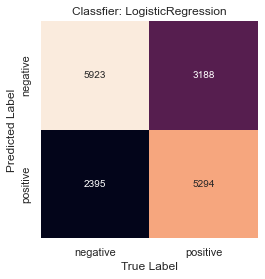

GaussianNB()


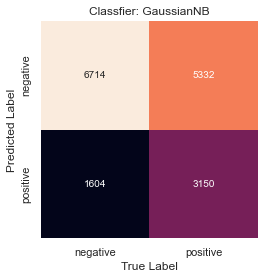

RandomForestClassifier()


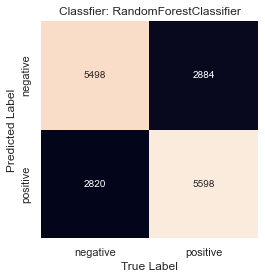

SVC()


In [ ]:
classifiers = {
    "Logistic Regression": lr(),
    "Gaussian Naive Bayes": gnb(),
    "Random Forest Classifier": rfc(),
    "Support Vector Classifier": svc()}

for key, classifier in classifiers.items():
    print(classifier)
    model = classifier.fit(X_train_fM, y_train)
    y_pred = classifier.predict(X_test_fM)
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
                xticklabels = np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Classfier: {classifier.__class__.__name__}")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()